## Packages

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import os

import collections
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Lectura de les dades

In [2]:
print(tf. __version__)

2.6.0


In [3]:
os.getcwd()

'C:\\Users\\aidaf\\TFG'

In [4]:
data_dir = os.path.join(os.getcwd() + "\\lung_colon_image_set")
data_dir

'C:\\Users\\aidaf\\TFG\\lung_colon_image_set'

In [5]:
classes = os. listdir(data_dir)
print(classes)

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


In [6]:
dades_Y = np.load('labels.npy')
dades_X = np.load('images.npy')

(25000,)

## Descripció de les dades

Dimensió: 

In [8]:
print('Dimensions de les dades : ', dades_X.shape, dades_Y.shape)

Dimensions de les dades :  (25000, 100, 100, 3) (25000,)


Nombre de classes i etiquetes: 

In [9]:
n_classes = len(classes)
print('Nombre de classes : ', n_classes)
print('Etiquetes de les classes : ', classes)

Nombre de classes :  5
Etiquetes de les classes :  ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


Distribució de les classes: 

In [10]:
ocurrences=collections.Counter(dades_Y)

print("Distribució de les classes : ",ocurrences)

Distribució de les classes :  Counter({3: 5000, 1: 5000, 4: 5000, 2: 5000, 0: 5000})


([<matplotlib.patches.Wedge at 0x1f511bde670>,
 [Text(0.8899186877588753, 0.6465637858537406, 'colon_aca'),
  Text(-0.3399187231970732, 1.046162158377023, 'colon_n'),
  Text(-1.0999999999999988, -5.149471622296949e-08, 'lung_aca'),
  Text(-0.33991862524830174, -1.0461621902025062, 'lung_n'),
  Text(0.8899187482945414, -0.6465637025335375, 'lung_scc')])

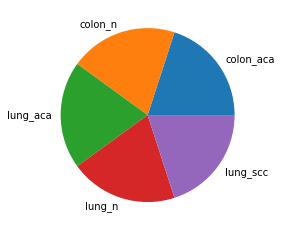

In [11]:
plt.pie(list(ocurrences.values()), labels=classes)

Visualització d'un exemple de cada categoria: 

In [12]:
def print_classes(clas):
    for cat in clas:
        files=os.listdir(os.path.join(os.getcwd()+'\\lung_colon_image_set\\'+ cat))
        d=random.choice(files)
        img=(os.path.join(os.getcwd()+'\\lung_colon_image_set\\'+ cat)+"\\"+d)
        
        plt.figure()
        plt.imshow(load_img(img))
        plt.title("Ground Truth : {}".format(cat))

Possibles confusions entre categories a simple vista:

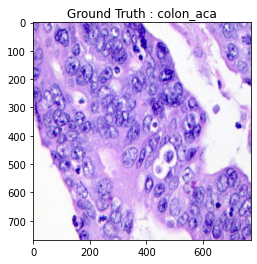

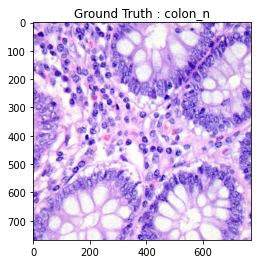

In [13]:
category=["colon_aca","colon_n"] # seleccionar les categories que es puguin confondre entre si

print_classes(category)

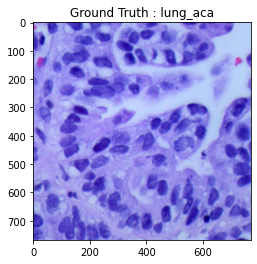

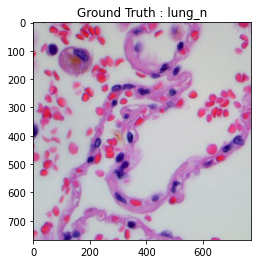

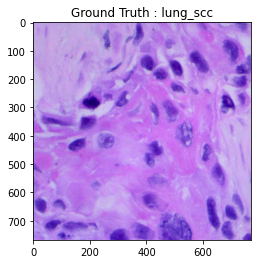

In [14]:
category=["lung_aca","lung_n","lung_scc"] # seleccionar les categories que es puguin confondre entre si

print_classes(category)

## Pre-processing

One-hot:

In [15]:
dades_Y_one_hot = np.array(pd.get_dummies(dades_Y))
dades_Y_one_hot = dades_Y_one_hot.astype('float32')
dades_Y_one_hot.shape

(25000, 5)

In [16]:
dades_X.shape

(25000, 100, 100, 3)

Split validation-train:

In [17]:
train_X,valid_X,train_label,valid_label = train_test_split(dades_X, dades_Y_one_hot, test_size=0.1, 
                                                           random_state=13,stratify=dades_Y_one_hot)

In [18]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((22500, 100, 100, 3), (2500, 100, 100, 3), (22500, 5), (2500, 5))

Mostrem que efectivament la mostra de validació està estratificada per classes:

In [20]:
ocurrences2=collections.Counter(np.argmax(np.round(valid_label),axis=1))

print("Distribució de les classes : ",ocurrences2)

Distribució de les classes :  Counter({0: 500, 4: 500, 2: 500, 1: 500, 3: 500})


## Model

In [21]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(dades_X.shape[1],dades_X.shape[2],3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(Dense(n_classes, activation='softmax'))

In [22]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0

In [24]:
# fit model on the augmented dataset
# initialize the number of epochs and batch size
EPOCHS = 20
BS = 512

# train the network
H = model.fit(train_X, train_label, batch_size=BS, epochs=EPOCHS,
              verbose=1, validation_data=(valid_X, valid_label))

Epoch 1/10
40/40 [==============================] - 303s 7s/step - loss: 1.0890 - accuracy: 0.5664 - val_loss: 0.6029 - val_accuracy: 0.7768
Epoch 2/10
40/40 [==============================] - 277s 7s/step - loss: 0.5436 - accuracy: 0.7719 - val_loss: 0.4824 - val_accuracy: 0.7732
Epoch 3/10
40/40 [==============================] - 264s 7s/step - loss: 0.4070 - accuracy: 0.8334 - val_loss: 0.3064 - val_accuracy: 0.8856
Epoch 4/10
40/40 [==============================] - 263s 7s/step - loss: 0.3479 - accuracy: 0.8570 - val_loss: 0.2958 - val_accuracy: 0.8712
Epoch 5/10
40/40 [==============================] - 266s 7s/step - loss: 0.3189 - accuracy: 0.8696 - val_loss: 0.2329 - val_accuracy: 0.9148
Epoch 6/10
40/40 [==============================] - 270s 7s/step - loss: 0.2695 - accuracy: 0.8903 - val_loss: 0.2202 - val_accuracy: 0.9192
Epoch 7/10
40/40 [==============================] - 267s 7s/step - loss: 0.2288 - accuracy: 0.9120 - val_loss: 0.2129 - val_accuracy: 0.9144
Epoch 8/10
40

In [25]:
model.save("def_model.h5")

In [26]:
def_model = keras.models.load_model('def_model.h5')
test_eval = def_model.evaluate(valid_X,valid_label, verbose=0)

In [27]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.16999025642871857
Test accuracy: 0.9359999895095825


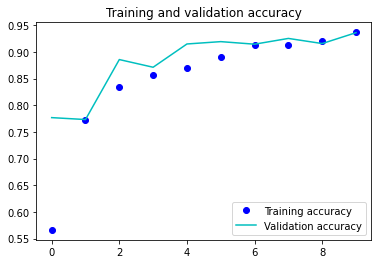

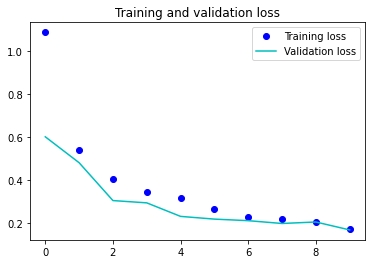

In [28]:
accuracy = H.history['accuracy']
val_accuracy = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'c', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'c', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [29]:
predicted_classes = def_model.predict(valid_X)

In [30]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
valid_labels = np.argmax(np.round(valid_label),axis=1)

In [31]:
target_names = ["Class {}".format(i) for i in range(21)]
print(classification_report(valid_labels, predicted_classes, target_names=classes))

              precision    recall  f1-score   support

   colon_aca       0.95      0.94      0.94       500
     colon_n       0.94      0.95      0.95       500
    lung_aca       0.87      0.92      0.90       500
      lung_n       1.00      0.99      0.99       500
    lung_scc       0.93      0.88      0.90       500

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



In [32]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

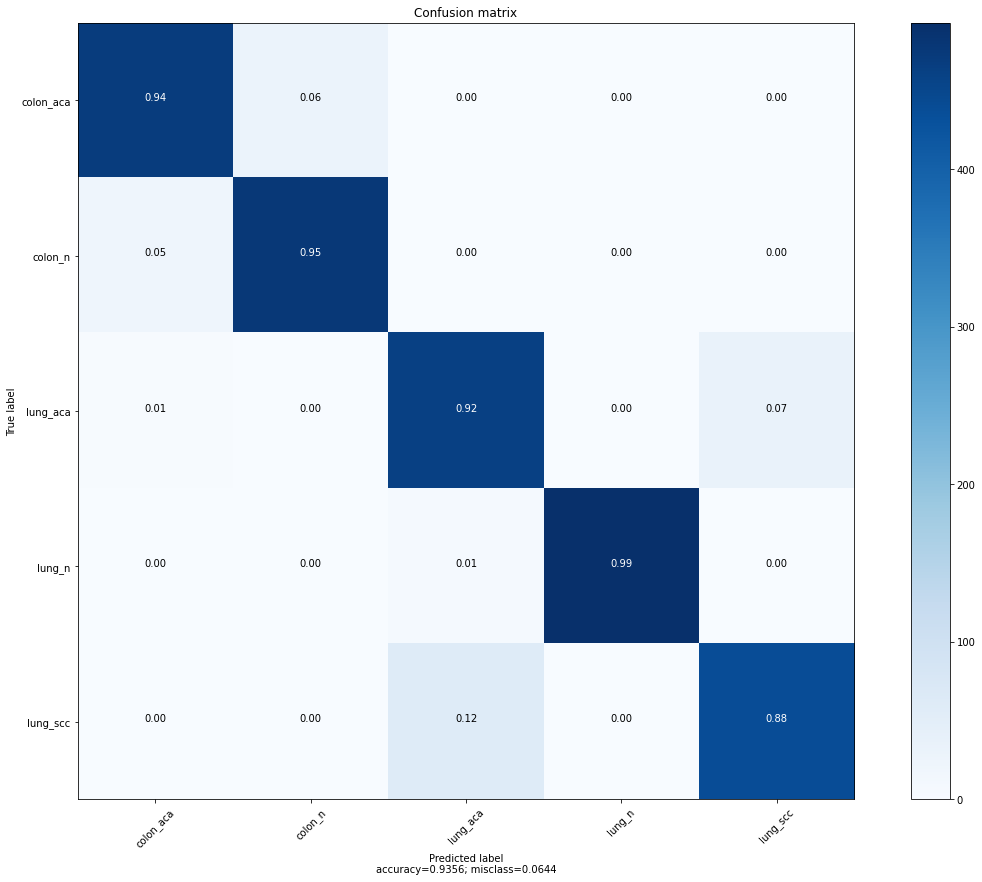

In [33]:
plot_confusion_matrix(confusion_matrix(valid_labels, predicted_classes), target_names = classes)

## Cross-validation

In [35]:
# Merge inputs and targets
inputs = np.concatenate((train_X, valid_X), axis=0)
targets = np.concatenate((train_label, valid_label), axis=0)

acc_per_fold = []
loss_per_fold = []

FOLDS = 5
EPOCHS = 10
BS = 256

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True)

# Define Data Augmentation

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, np.argmax(np.round(targets),axis=1)):

    # Define the model architecture
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(dades_X.shape[1],dades_X.shape[2],3)))
    model.add(Conv2D(32, kernel_size=(3, 3),activation='linear', padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2),padding='same'))
    model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Flatten())
    model.add(Dense(64, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])


    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(train_X, train_label, batch_size=BS, epochs=EPOCHS,
              verbose=1, validation_data=(valid_X, valid_label))
    
    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
80/80 [==============================] - 401s 4s/step - loss: 1.0427 - accuracy: 0.6227 - val_loss: 0.7081 - val_accuracy: 0.7004
Epoch 2/10
80/80 [==============================] - 276s 3s/step - loss: 0.5138 - accuracy: 0.7749 - val_loss: 0.3940 - val_accuracy: 0.8476
Epoch 3/10
80/80 [==============================] - 275s 3s/step - loss: 0.3966 - accuracy: 0.8361 - val_loss: 0.4009 - val_accuracy: 0.8160
Epoch 4/10
80/80 [==============================] - 285s 4s/step - loss: 0.3513 - accuracy: 0.8553 - val_loss: 0.2751 - val_accuracy: 0.8888
Epoch 5/10
80/80 [==============================] - 299s 4s/step - loss: 0.2859 - accuracy: 0.8842 - val_loss: 0.2605 - val_accuracy: 0.8940
Epoch 6/10
80/80 [==============================] - 304s 4s/step - loss: 0.2552 - accuracy: 0.8969 - val_loss: 0.2246 - val_accuracy: 0.9232
Epoch 7/10
80/80 [==============================] - 281s 

In [36]:
acc_per_fold

[96.65933847427368,
 98.00000190734863,
 86.04395389556885,
 96.46154046058655,
 97.80219793319702]

In [37]:
print("Estimació accuracy dels kfolds:",sum(acc_per_fold)/len(acc_per_fold))

Estimació accuracy dels kfolds: 94.99340653419495
